In [1]:
# !pip install -U segmentation-models-pytorch albumentations --user
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import linzhutils as lu
from segdataset import Dataset
from torch.utils.data import DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [2]:
DATA_DIR = '/scratch/project_2007251/data/hel20xx'

IMAGE_DIR = 'images'
MASK_DIR = 'kussi_masks'
VAL_IMAGE_DIR = 'val_' + IMAGE_DIR
VAL_MASK_DIR = 'val_' + MASK_DIR

img_dir = os.path.join(DATA_DIR, IMAGE_DIR)
anno_dir = os.path.join(DATA_DIR, MASK_DIR)

val_img_dir = os.path.join(DATA_DIR, VAL_IMAGE_DIR)
val_anno_dir = os.path.join(DATA_DIR, VAL_MASK_DIR)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(512, 512)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [3]:
# load best saved checkpoint
model = torch.load('./models/kussi_efficientnet-b7_7_0.490.pth')
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['kussi']

In [4]:
from segmentation_models_pytorch import utils as smpu

loss = smp.losses.DiceLoss('binary')
loss.__name__ = 'focal_loss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [5]:
# create test dataset

test_dataset = Dataset(
    val_img_dir,
    val_anno_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [6]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    val_img_dir,
    val_anno_dir,
    classes=CLASSES,
)


# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
# evaluate model on test set
# test_epoch = smp.utils.train.ValidEpoch(
#     model=best_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

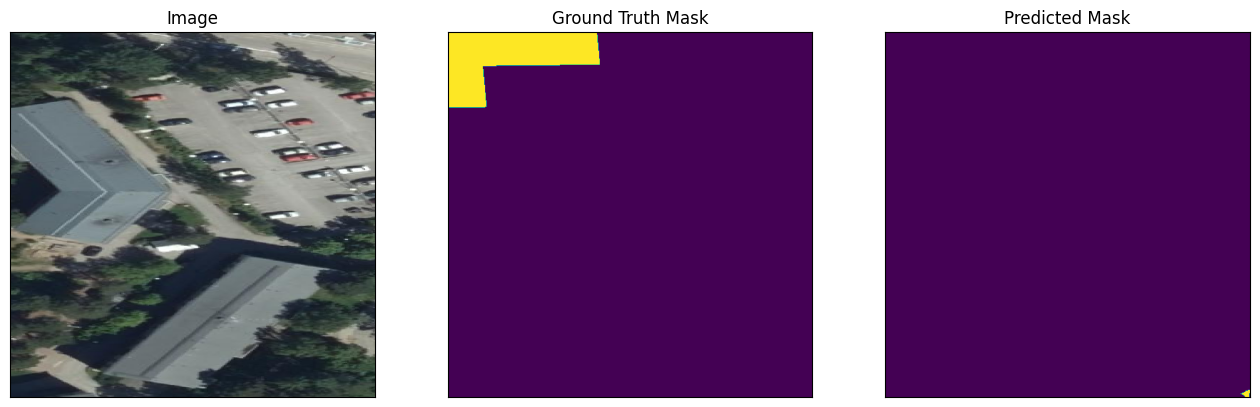

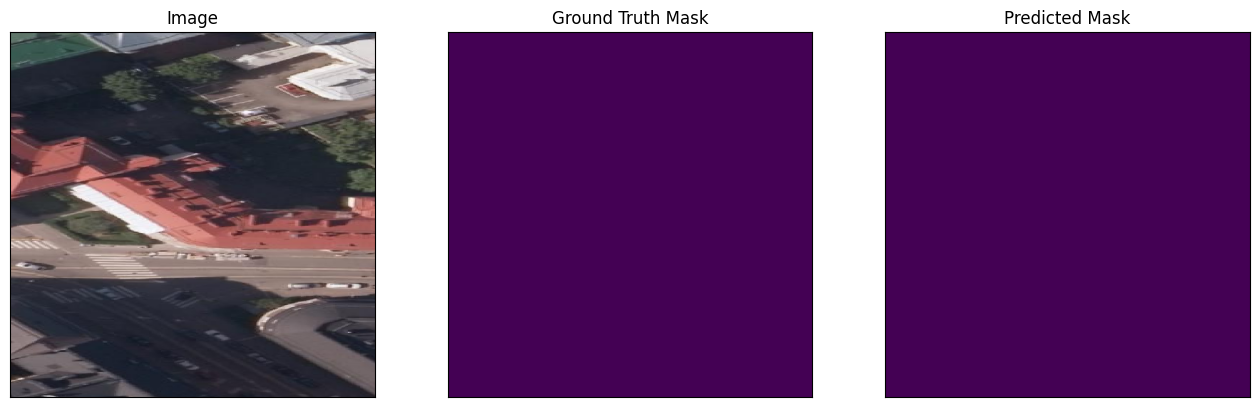

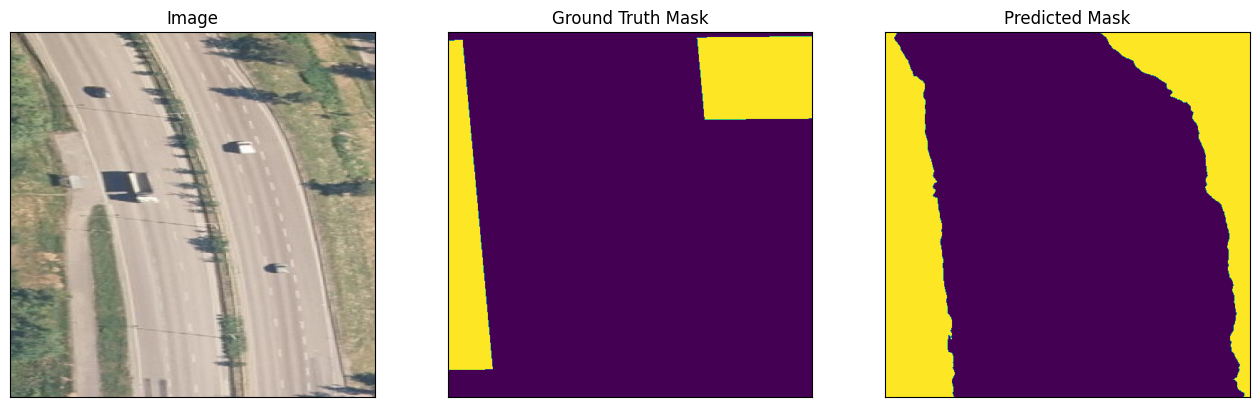

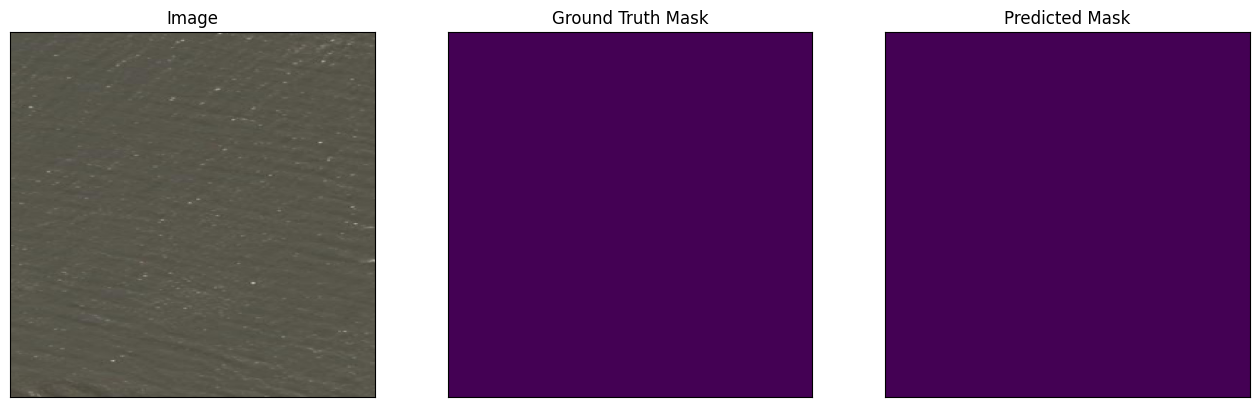

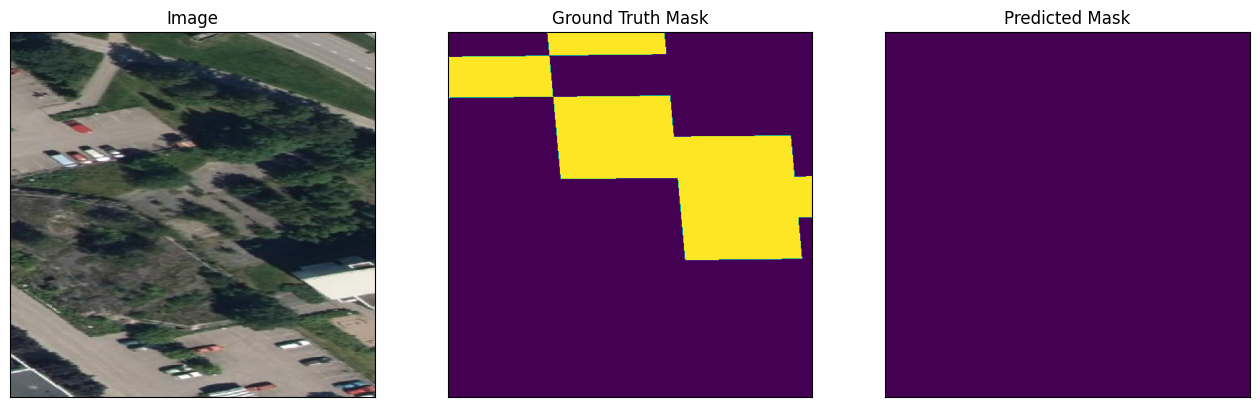

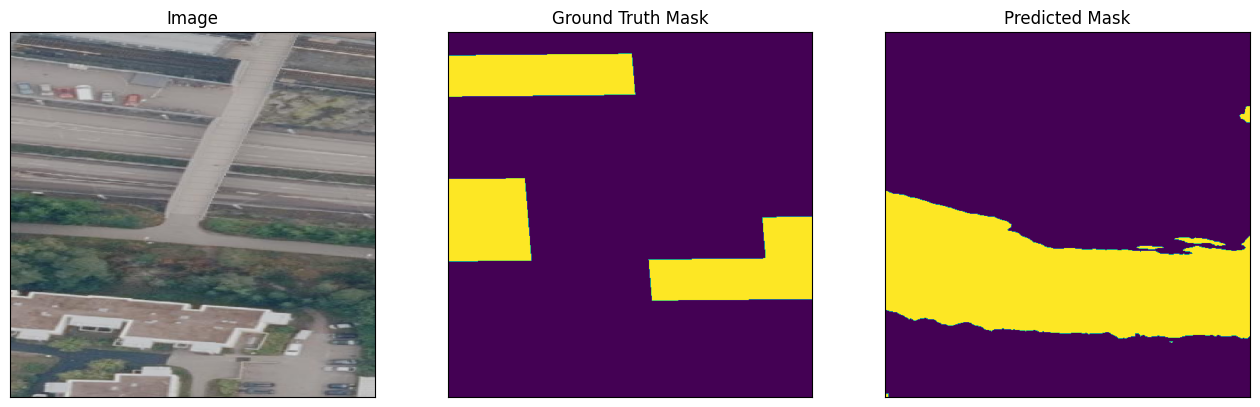

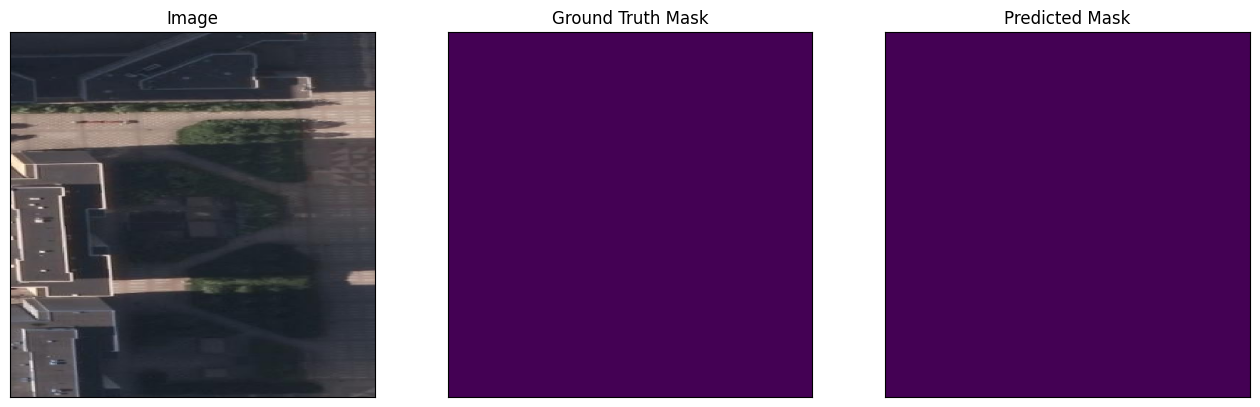

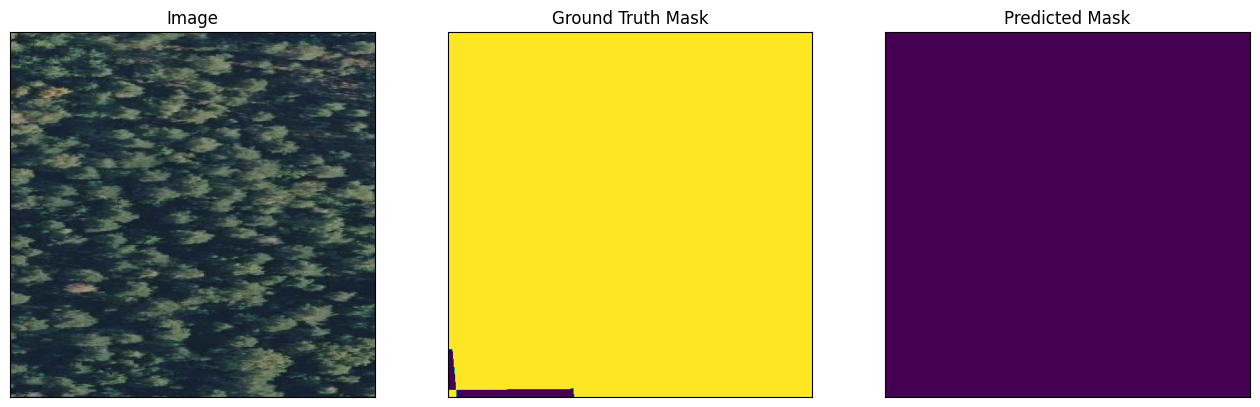

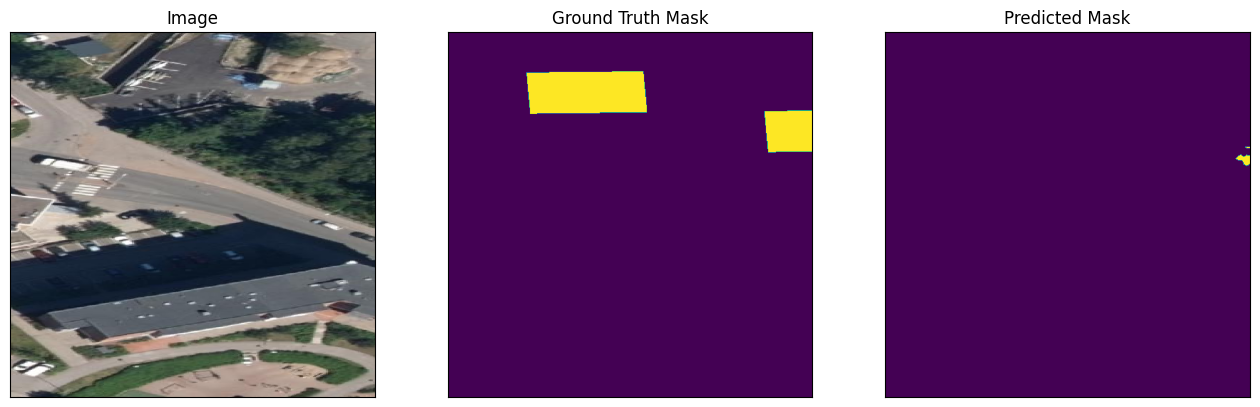

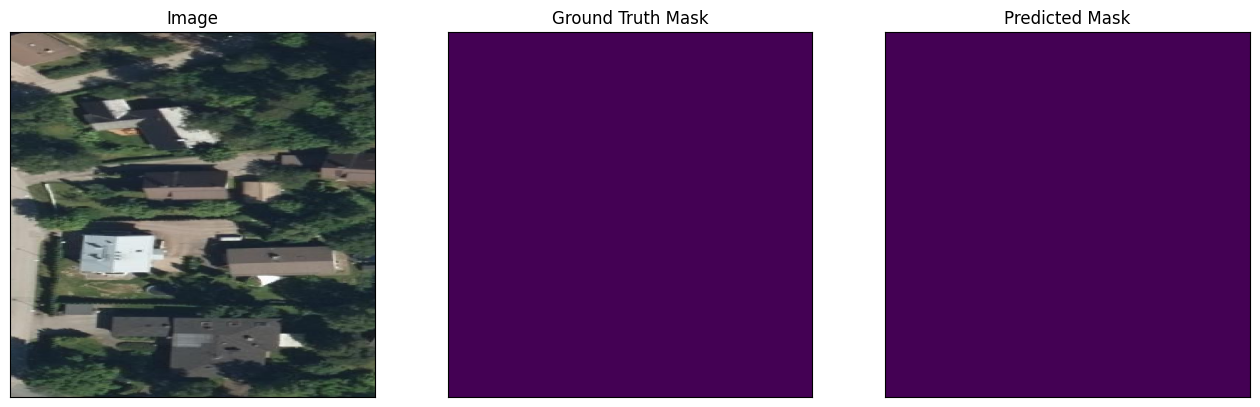

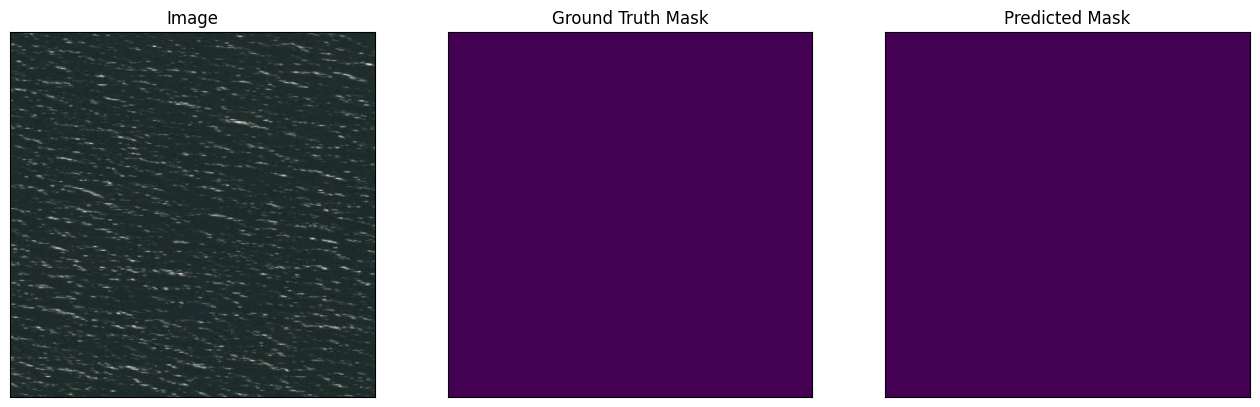

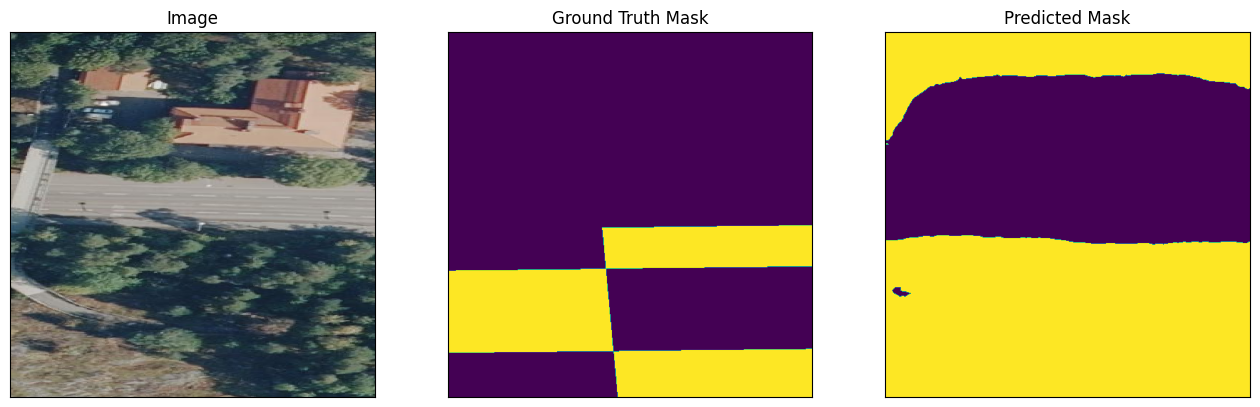

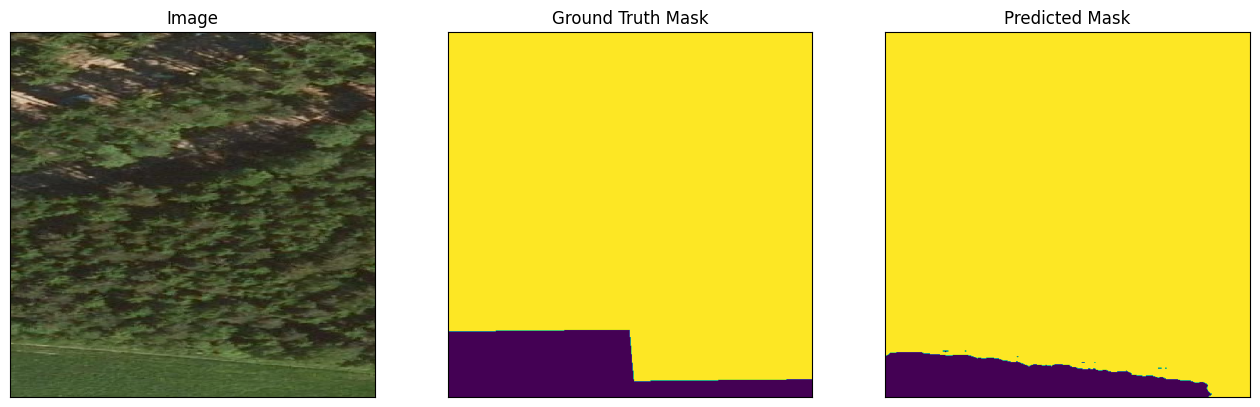

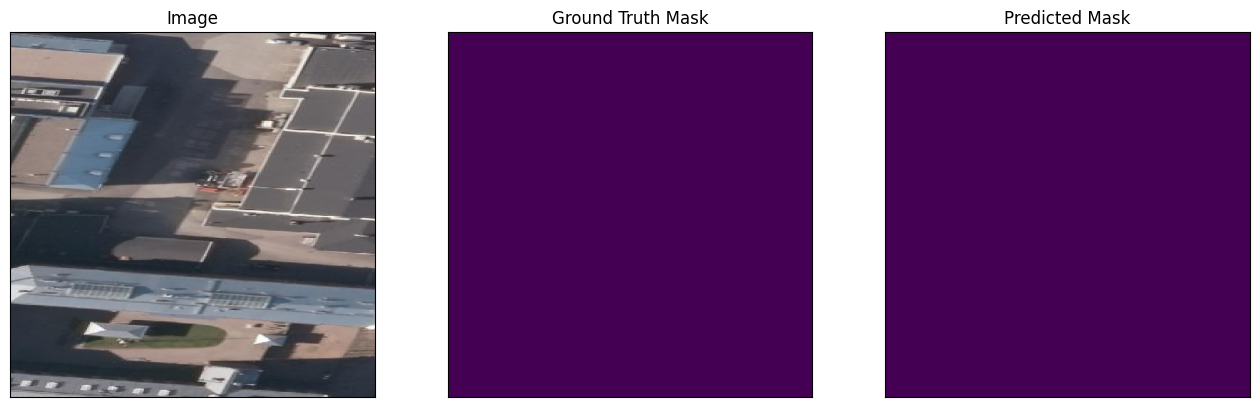

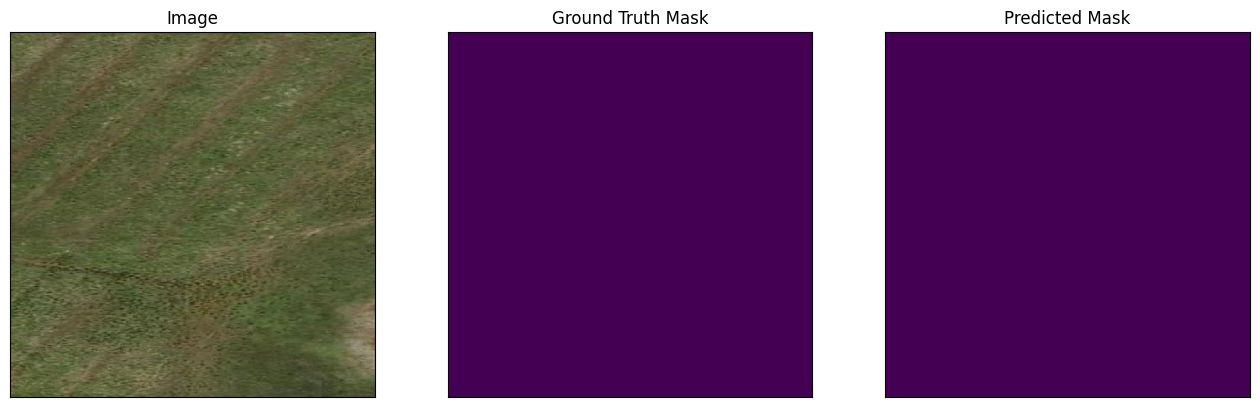

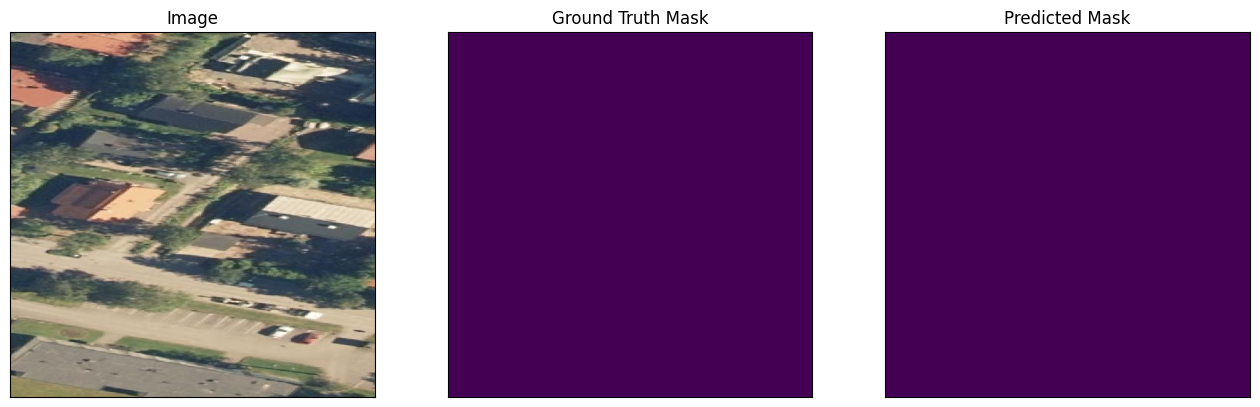

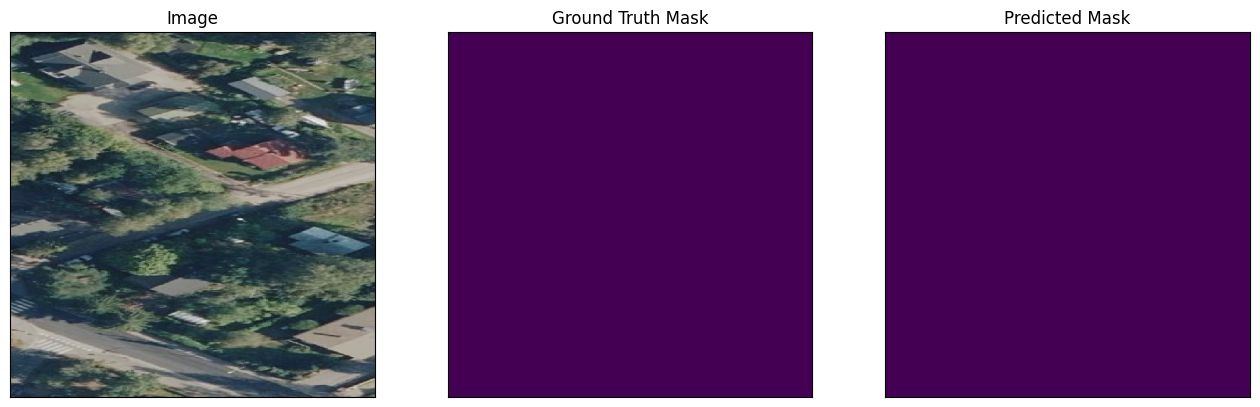

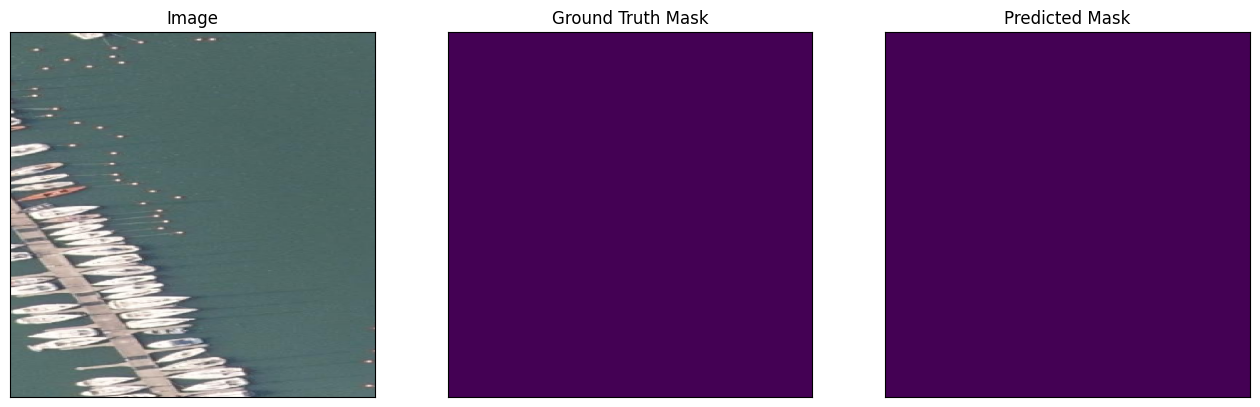

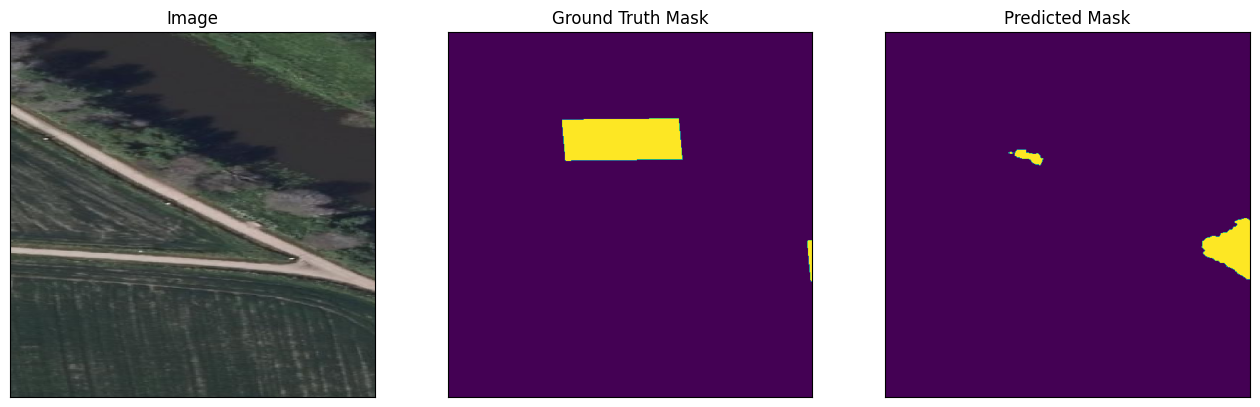

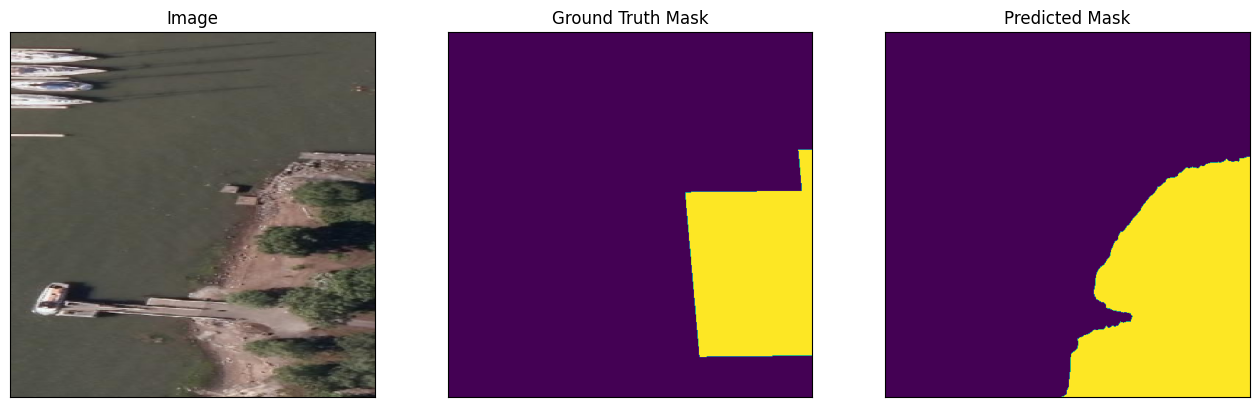

In [9]:
for i in range(20):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(image=image_vis,
              ground_truth_mask=gt_mask,
              predicted_mask=pr_mask)
